In [1]:
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor 
import matplotlib.pyplot as plt
import os.path
from os import path
from sklearn.neural_network import MLPRegressor

In [2]:
def LoadRawVariables():
    c2pt = []
    ts   = []
    taus = []
    xs   = []
    ys   = []
    zs   = []
    c3pt_S = []
    c3pt_V = []
    c3pt_A = []
    c2pt_OTHER = []
    
    
    for tau in range(0, 49, 8):
        for x in range(0, 25, 8):
            for y in range(0, 25, 8):
                for z in range(0, 25, 8):
                    for sample in range(748, 1421, 16):
                        fname = "../Data/T" + str(tau) + "/x" + str(x) + "y" + str(y) + "z" + str(z) + "/nuc3pt.dat." + str(sample)
                        if path.exists(fname):
                            with open(fname) as fp:
                                for i, line in enumerate(fp):
                                    if i >= 7 and i <= 70:           # The start of Gauss -> Point 2pt correlation functions
                                        c2pt_OTHER.append([float(x) for x in line.rstrip().split()[1:3]])
                                    if i >= 5182 and i <= 5245:      # The start of Gauss -> Gauss 2pt correlation functions
                                        c2pt.append([float(x) for x in line.rstrip().split()[1:3]])
                                        ts.append(i - 5182)
                                        taus.append(tau)
                                        xs.append(x)
                                        ys.append(y)
                                        zs.append(z)
                                    elif i >= 10154 and i <= 10217:
                                        c3pt_S.append([float(x) for x in line.rstrip().split()[1:5]])
                                    elif i >= 10229 and i <= 10292:
                                        c3pt_V.append([float(x) for x in line.rstrip().split()[1:5]])
                                    elif i >= 19979 and i <= 20042:
                                        c3pt_A.append([float(x) for x in line.rstrip().split()[1:5]])
                                    elif i > 20042:
                                        break
    
    return ts, taus, xs, ys, zs, c2pt, c3pt_S, c3pt_V, c3pt_A, c2pt_OTHER

ts, taus, xs, ys, zs, c2pt, c3pt_S, c3pt_V, c3pt_A, c2pt_OTHER = LoadRawVariables()

c2pt_factor_raw = sum(np.array(c2pt)) / len(c2pt)
N_factor = np.sqrt(c2pt_factor_raw[0] ** 2 + c2pt_factor_raw[1] ** 2)

for i in range(len(c2pt)):
    for j in range(2):
        c2pt[i][j] /= N_factor
        c2pt_OTHER[i][j] /= N_factor
    for j in range(4):
        c3pt_S[i][j] /= N_factor
        c3pt_V[i][j] /= N_factor
        c3pt_A[i][j] /= N_factor

## Prediction of c3pt at each time slice

In [3]:
## Features is a 64 x <# Data> x <Size Data> 3D array for all 64 sets of lists of features
## Labels is a 64 x <# Data> 2D array for all 64 sets of lists of labels

features_unshifted = np.array([[taus[i]] + [c2pt[i + j][0] for j in range(64)] + [c2pt[i + j][1] for j in range(64)] for i in range(0, len(ts), 64)])
features = []
for i in range(64):
    features.append([])
    for f in features_unshifted:
        shift = int(f[0])
        features[i].append(np.roll(f[1:], -shift))

features = np.array(features)

labels_S_up = np.array([[c3pt_S[i+j][0] for i in range(0, len(c3pt_S), 64)] for j in range(64)])
labels_A_up = np.array([[c3pt_A[i+j][0] for i in range(0, len(c3pt_A), 64)] for j in range(64)])
labels_V_up = np.array([[c3pt_V[i+j][0] for i in range(0, len(c3pt_V), 64)] for j in range(64)])

labels_S_down = np.array([[c3pt_S[i+j][2] for i in range(0, len(c3pt_S), 64)] for j in range(64)])
labels_A_down = np.array([[c3pt_A[i+j][2] for i in range(0, len(c3pt_A), 64)] for j in range(64)])
labels_V_down = np.array([[c3pt_V[i+j][2] for i in range(0, len(c3pt_V), 64)] for j in range(64)])

## Scalar charge

In [4]:
labelFrac = 0.5
BCFrac = 0.1

labelEnd = int(len(labels_S_up[0]) * labelFrac)
BCEnd    = int(len(labels_S_up[0]) * (BCFrac + labelFrac))

X_train, Y_train_up, Y_train_down = features[:, :labelEnd], labels_S_up[:, :labelEnd], labels_S_down[:, :labelEnd]
X_bc, Y_bc_up, Y_bc_down = features[:, labelEnd:BCEnd], labels_S_up[:, labelEnd:BCEnd], labels_S_down[:, labelEnd:BCEnd]
X_test, Y_test_up, Y_test_down = features[:, BCEnd:], labels_S_up[:, BCEnd:], labels_S_down[:, BCEnd:]

gbr_up = list(range(64))
gbr_down = list(range(64))
biasCrxn_up = list(range(64))
biasCrxn_down = list(range(64))
for i in range(64):
    gbr_up[i] = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, max_depth=3)
    gbr_up[i].fit(X_train[i], Y_train_up[i])
    
    gbr_down[i] = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, max_depth=3)
    gbr_down[i].fit(X_train[i], Y_train_down[i])

    y_bc_pred_up = gbr_up[i].predict(X_bc[i])
    y_bc_pred_down = gbr_down[i].predict(X_bc[i])

    biasCrxn_up[i] = np.average(Y_bc_up - y_bc_pred_up)
    biasCrxn_down[i] = np.average(Y_bc_down - y_bc_pred_down)

Prediction quality @ t=0: 0.2160242116841916


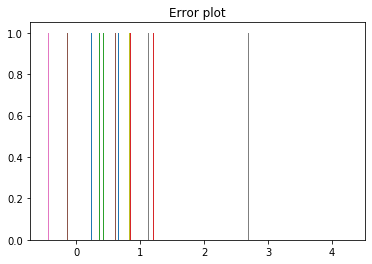

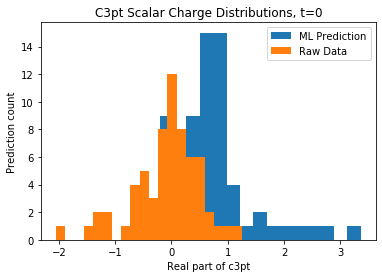

Prediction quality @ t=1: 0.2587080524643809


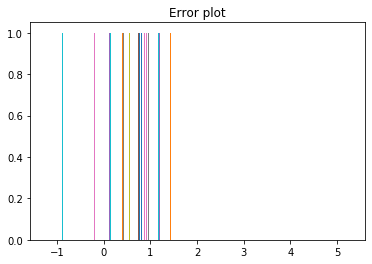

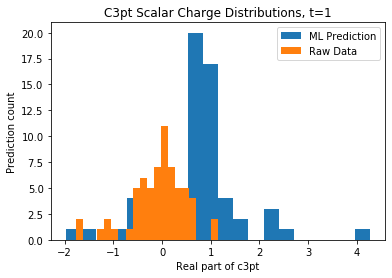

Prediction quality @ t=2: 0.3245633548773169


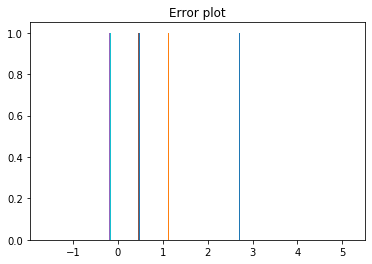

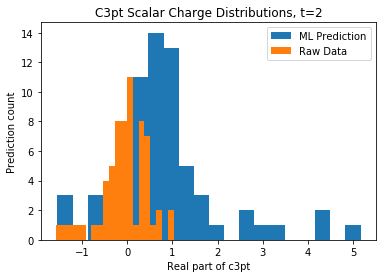

Prediction quality @ t=3: 0.41073970164360074


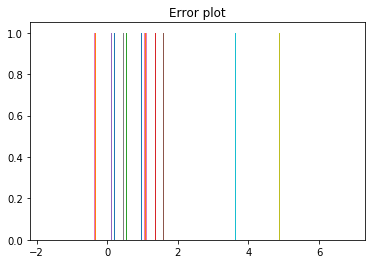

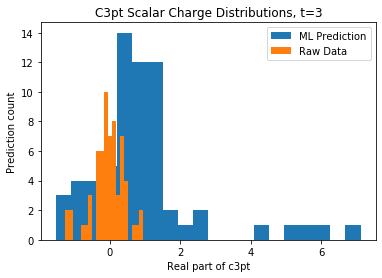

Prediction quality @ t=4: 0.39380666768525885


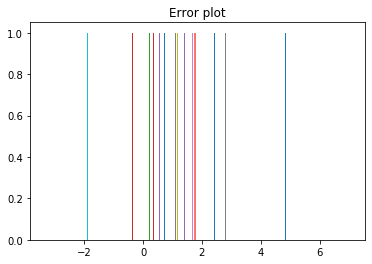

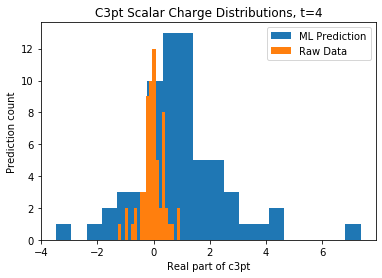

Prediction quality @ t=5: 0.47489236386253225


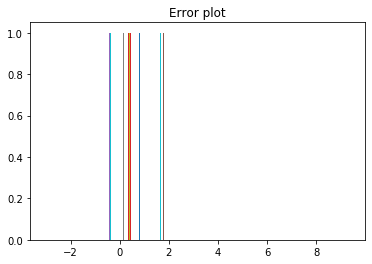

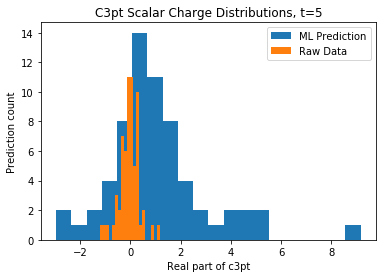

Prediction quality @ t=6: 0.5025865321929458


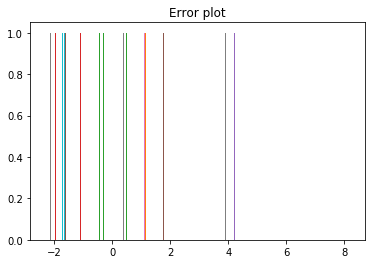

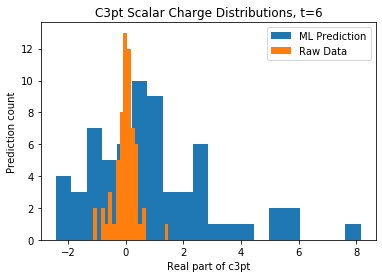

Prediction quality @ t=7: 0.5953170448418167


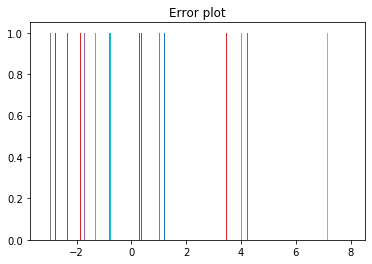

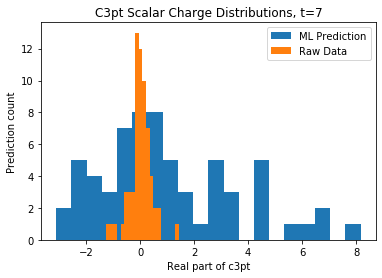

Prediction quality @ t=8: 0.6949387072126475


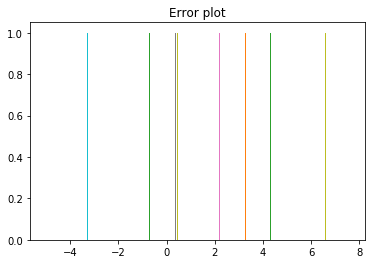

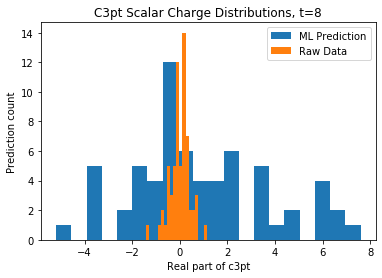

Prediction quality @ t=9: 20.433133148184016


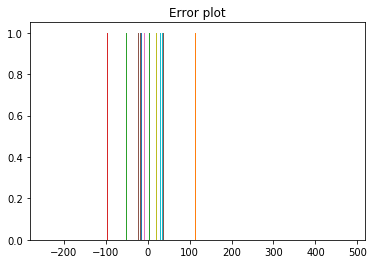

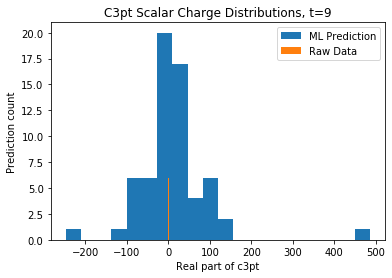

Prediction quality @ t=10: 1.14256728233156


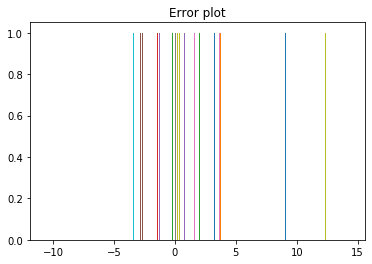

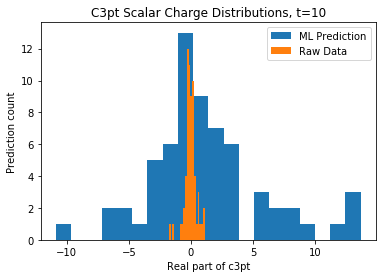

Prediction quality @ t=11: 1.1804223644021203


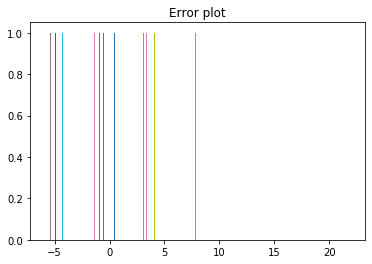

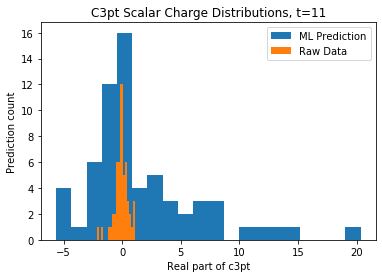

Prediction quality @ t=12: 1.2089784114314783


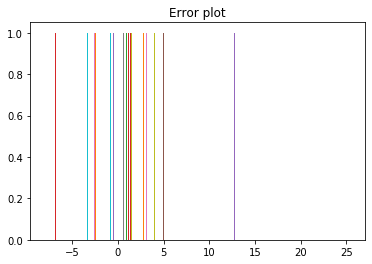

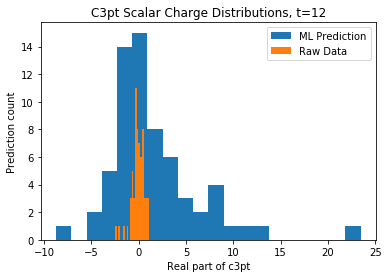

Prediction quality @ t=13: 1.1081760100680287


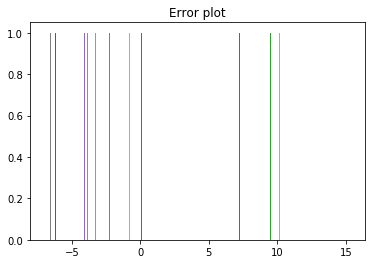

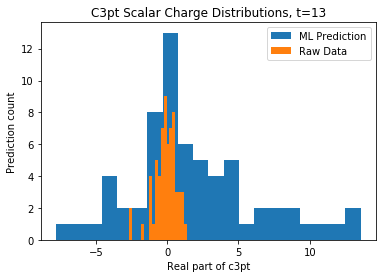

Prediction quality @ t=14: 1.188340180417969


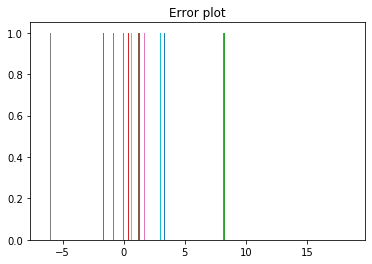

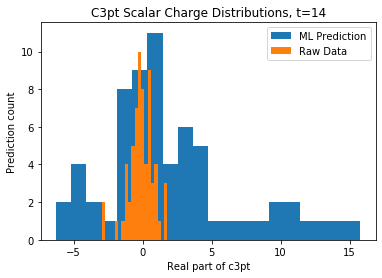

Prediction quality @ t=15: 1.3332937470403248


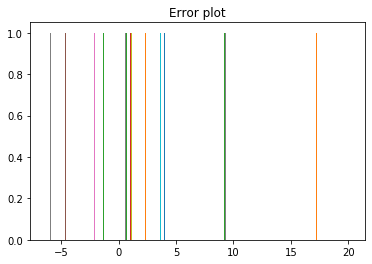

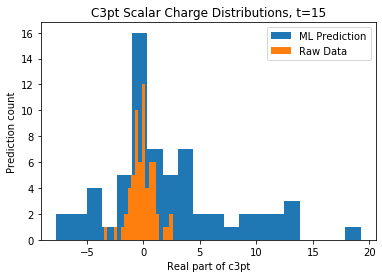

Prediction quality @ t=16: 1.415950441082177


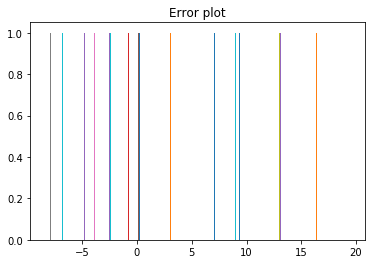

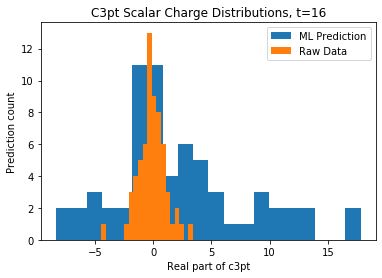

Prediction quality @ t=17: 56.402402318328974


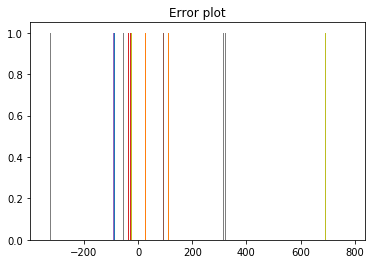

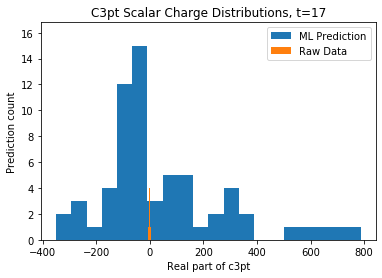

Prediction quality @ t=18: 1.2870944141330198


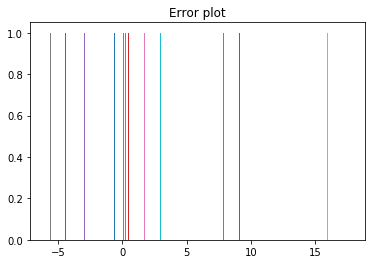

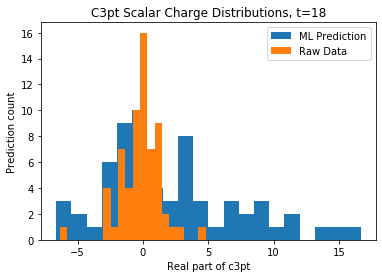

Prediction quality @ t=19: 1.2317385964176515


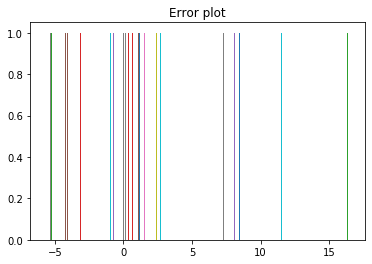

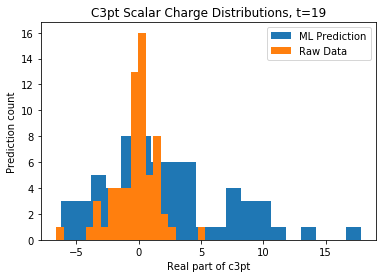

Prediction quality @ t=20: 1.135074480510889


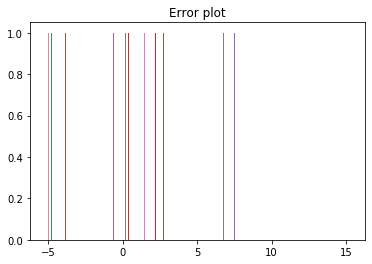

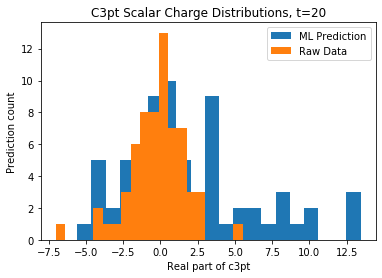

Prediction quality @ t=21: 1.133086291987987


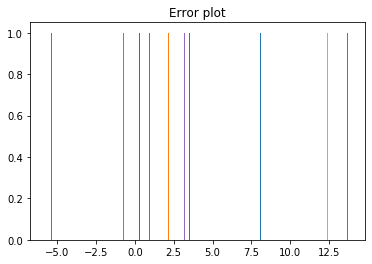

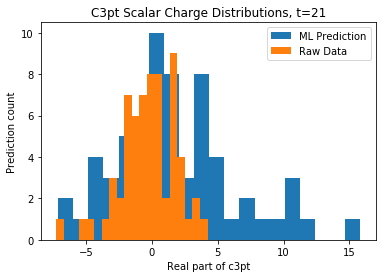

Prediction quality @ t=22: 1.1656530662760132


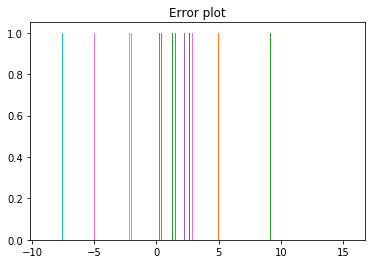

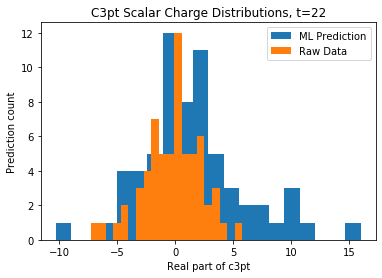

Prediction quality @ t=23: 1.2189479561963823


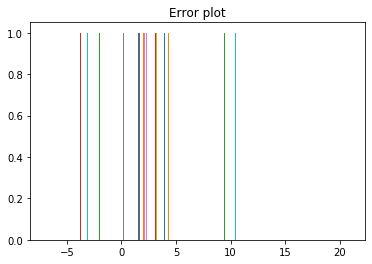

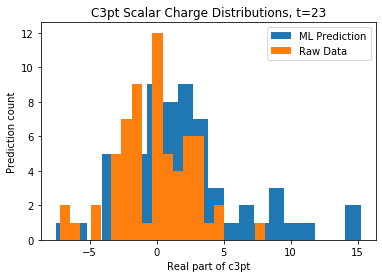

Prediction quality @ t=24: 1.1364869402549815


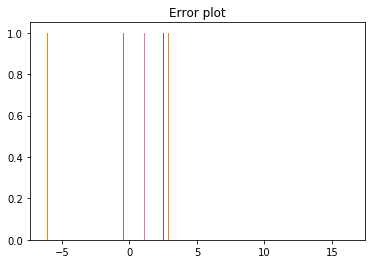

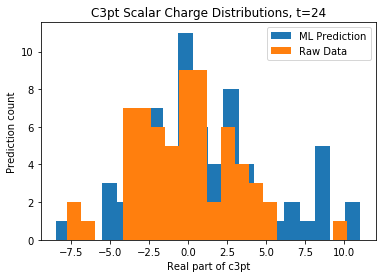

Prediction quality @ t=25: 63.49780010387811


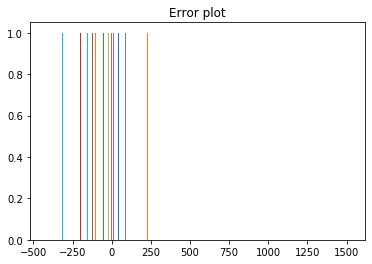

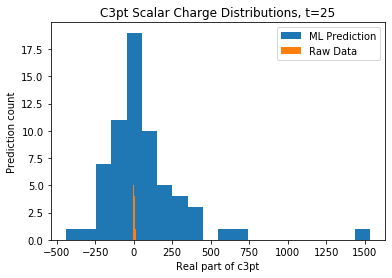

Prediction quality @ t=26: 1.193205708739484


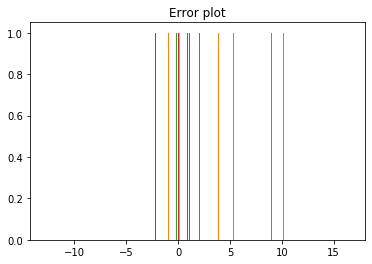

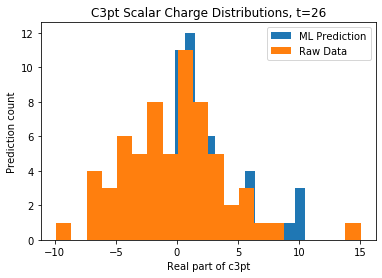

Prediction quality @ t=27: 1.3056317988671886


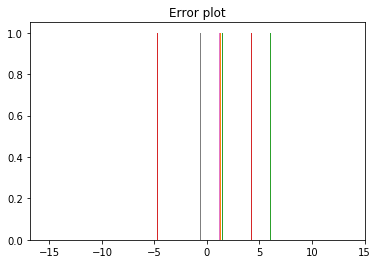

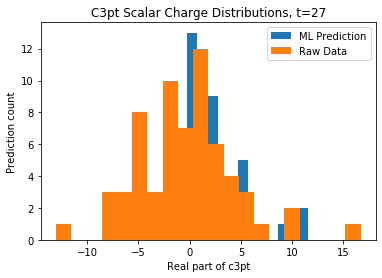

Prediction quality @ t=28: 1.3039190968210683


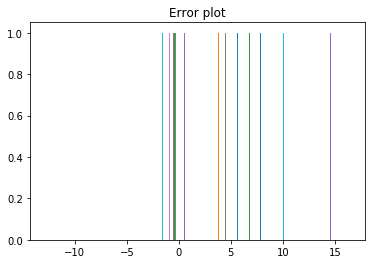

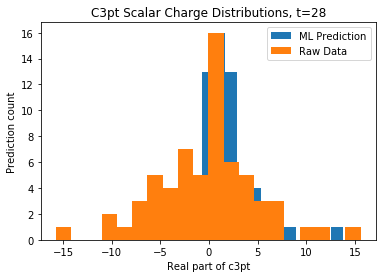

Prediction quality @ t=29: 1.3563600123903043


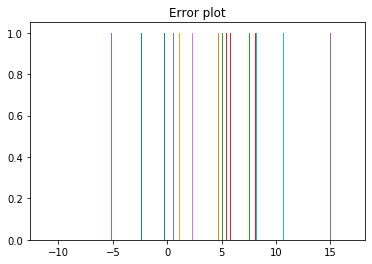

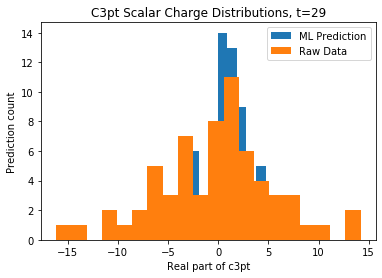

Prediction quality @ t=30: 1.5077075072504136


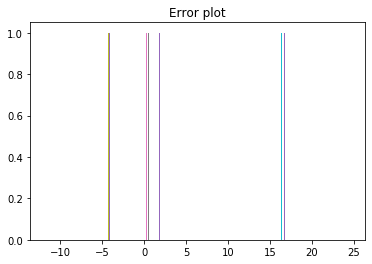

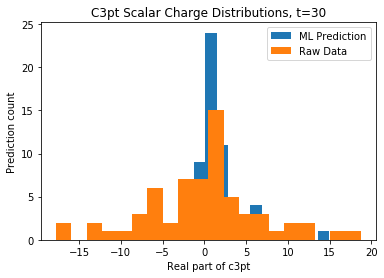

Prediction quality @ t=31: 1.6394675823557783


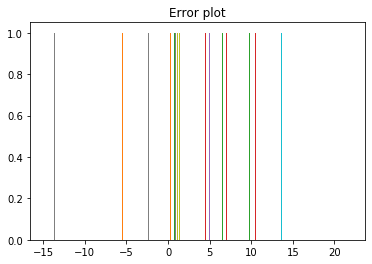

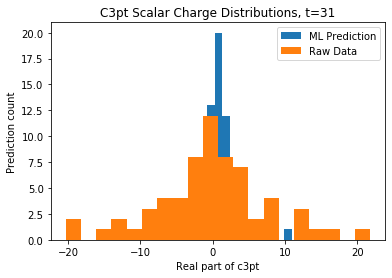

Prediction quality @ t=32: 1.7304581434101614


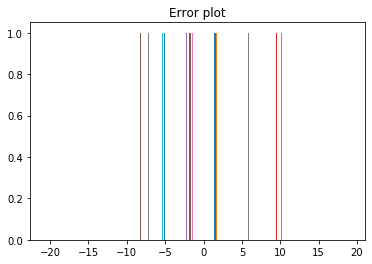

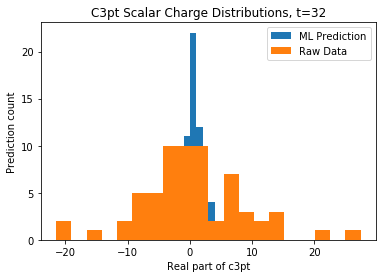

Prediction quality @ t=33: 31.224024473622023


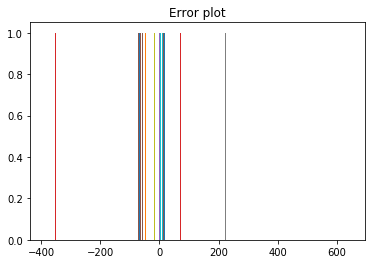

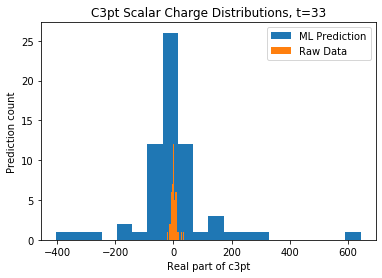

Prediction quality @ t=34: 2.0665596556871293


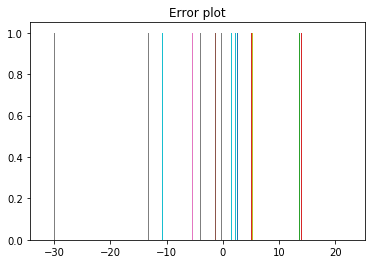

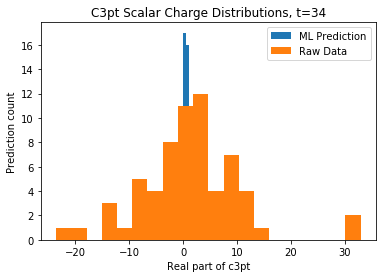

Prediction quality @ t=35: 2.1298507911505484


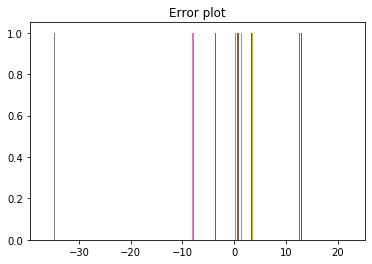

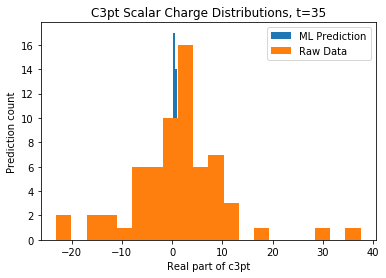

Prediction quality @ t=36: 2.189784599300226


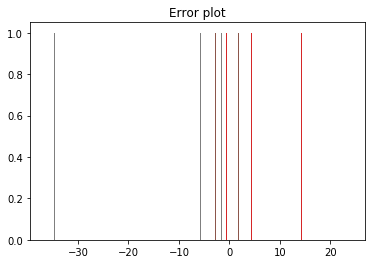

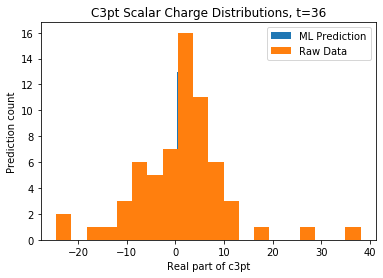

Prediction quality @ t=37: 2.166579856062445


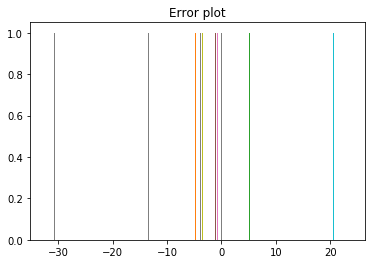

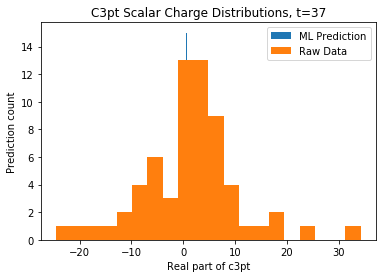

Prediction quality @ t=38: 2.1742927864813337


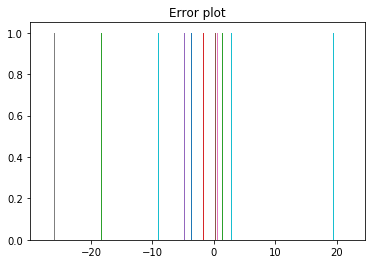

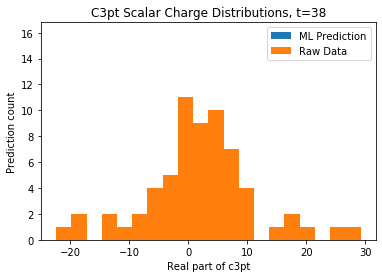

Prediction quality @ t=39: 2.2067763459358702


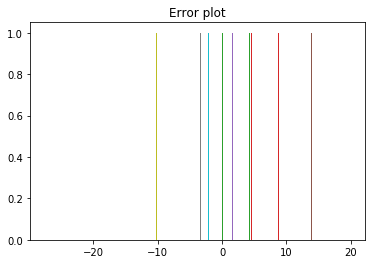

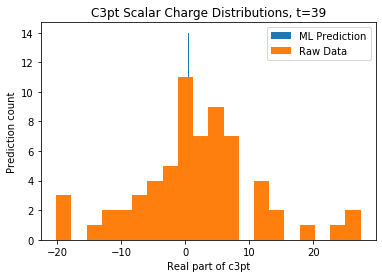

Prediction quality @ t=40: 2.181236077213837


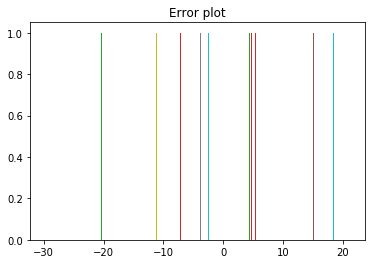

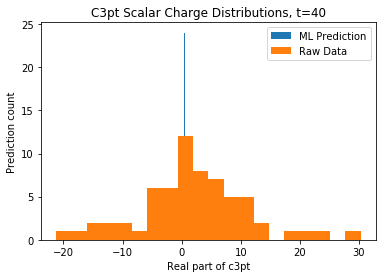

Prediction quality @ t=41: 186.8914054375906


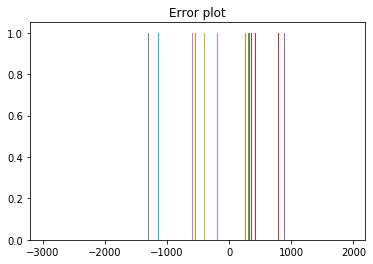

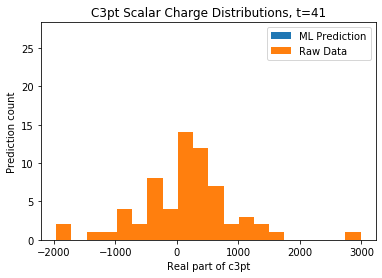

Prediction quality @ t=42: 1.8974517836015337


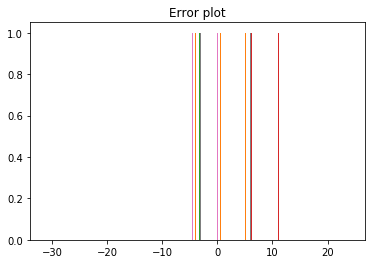

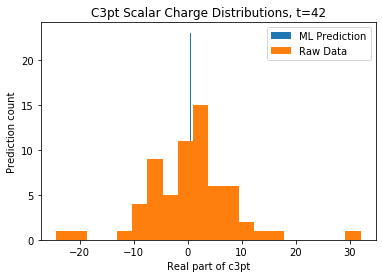

Prediction quality @ t=43: 1.5941795224528452


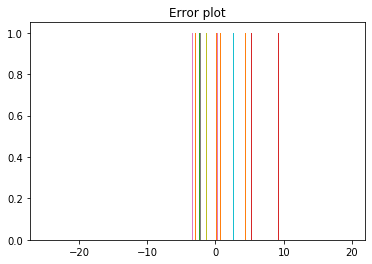

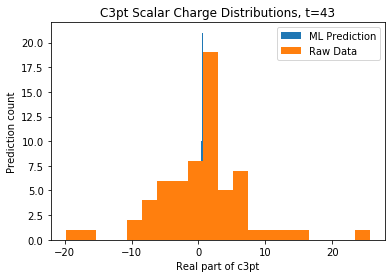

Prediction quality @ t=44: 1.3211388165408884


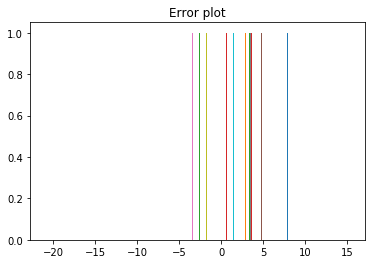

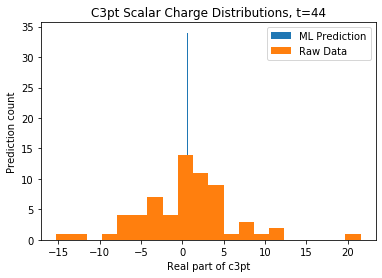

Prediction quality @ t=45: 1.0565117880516122


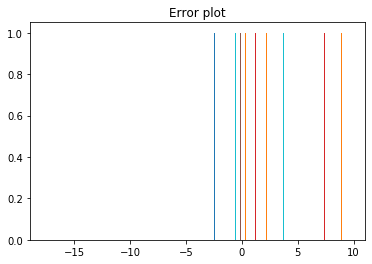

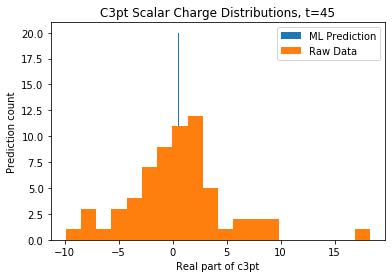

Prediction quality @ t=46: 0.8244642540866821


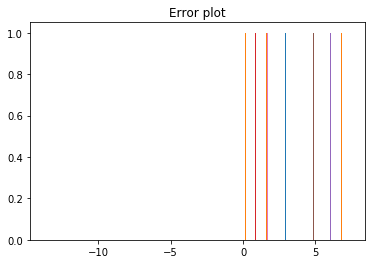

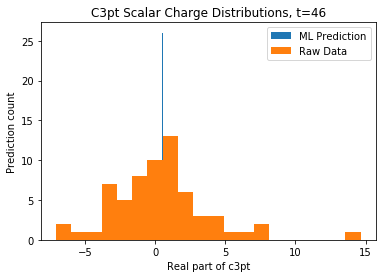

Prediction quality @ t=47: 0.6586125229252163


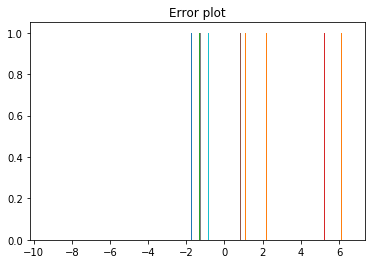

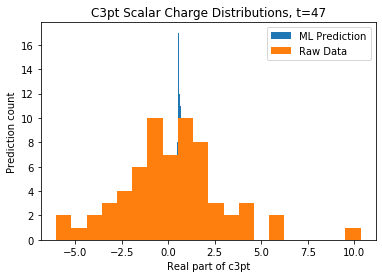

Prediction quality @ t=48: 0.5467880353051363


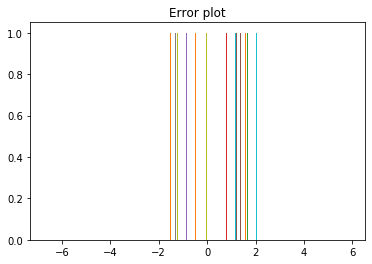

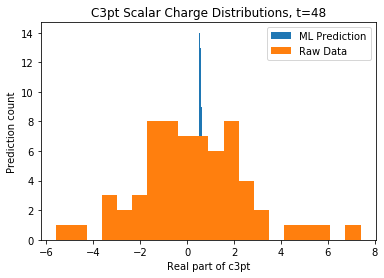

Prediction quality @ t=49: 0.5015685024988686


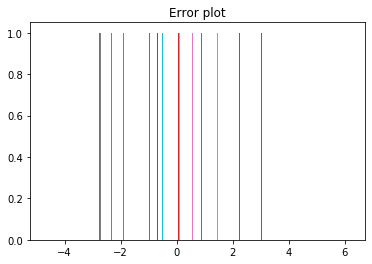

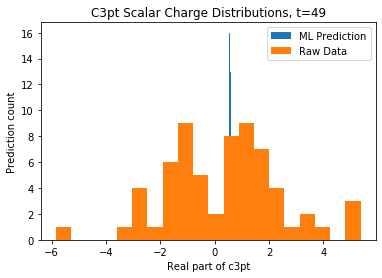

Prediction quality @ t=50: 0.488272203726035


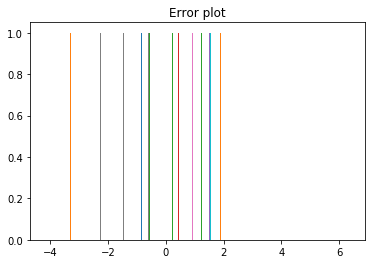

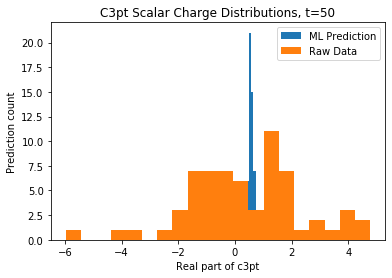

Prediction quality @ t=51: 0.4703932957800362


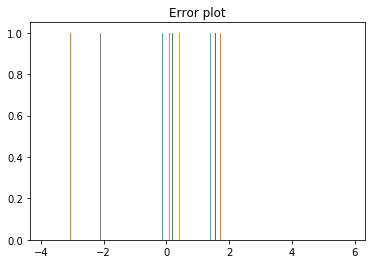

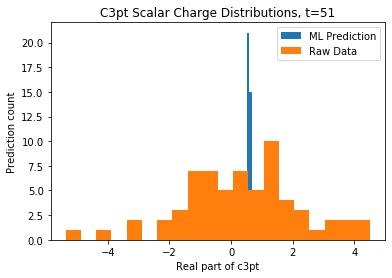

Prediction quality @ t=52: 0.4438548914729504


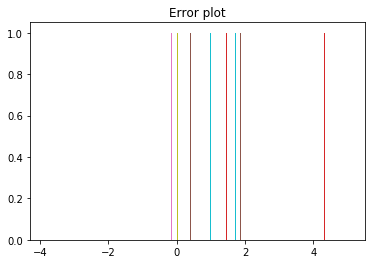

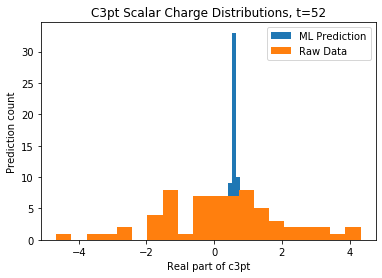

Prediction quality @ t=53: 0.3700895077152173


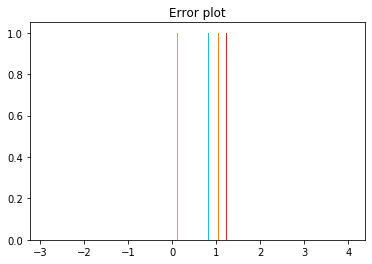

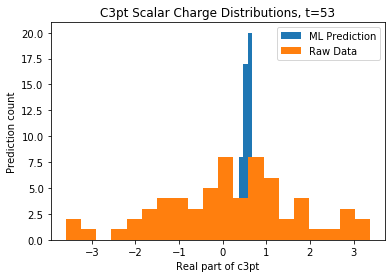

Prediction quality @ t=54: 0.31845619260121044


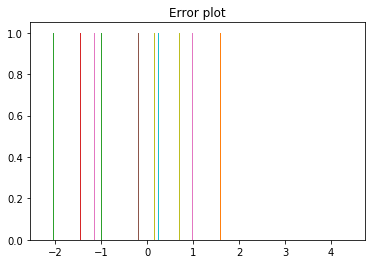

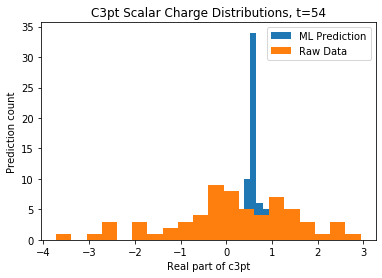

Prediction quality @ t=55: 0.292649315561663


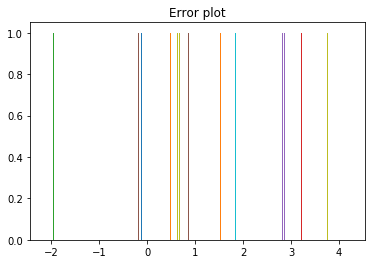

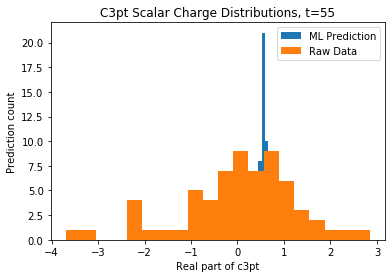

Prediction quality @ t=56: 0.2819842264605322


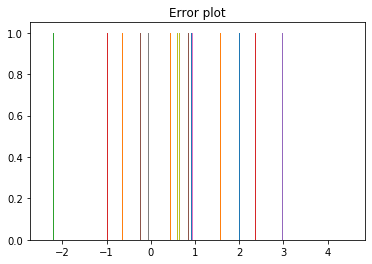

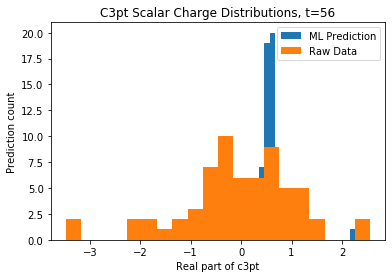

Prediction quality @ t=57: 0.2697711832252063


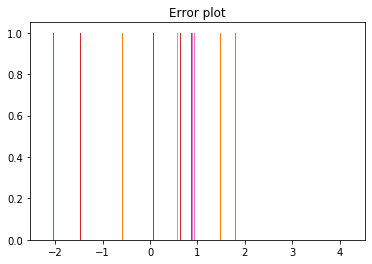

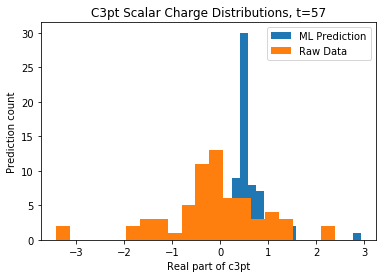

Prediction quality @ t=58: 0.26097735486539037


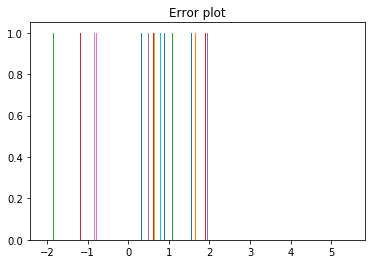

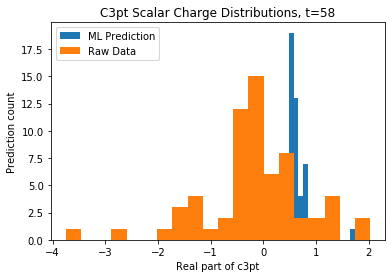

Prediction quality @ t=59: 0.23730726059788554


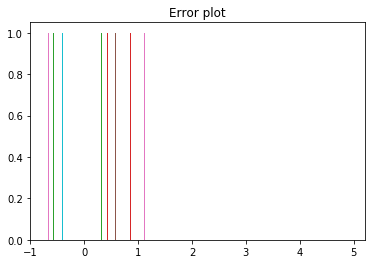

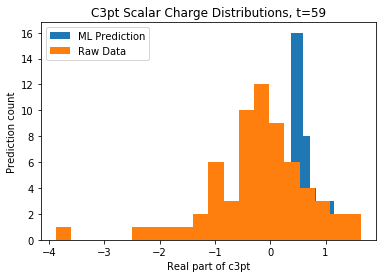

Prediction quality @ t=60: 0.2192133734637296


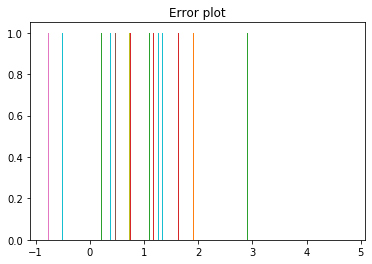

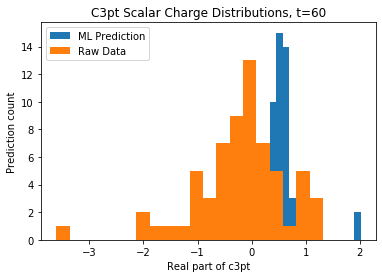

Prediction quality @ t=61: 0.21484348677655105


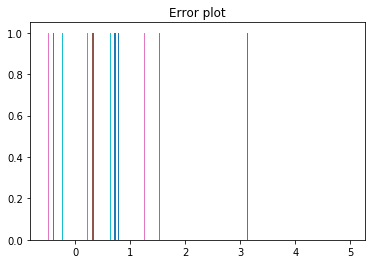

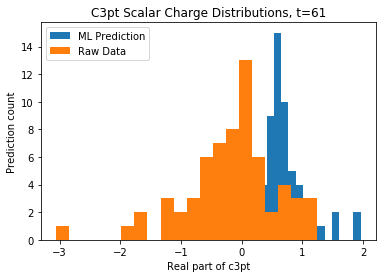

Prediction quality @ t=62: 0.21722844486001563


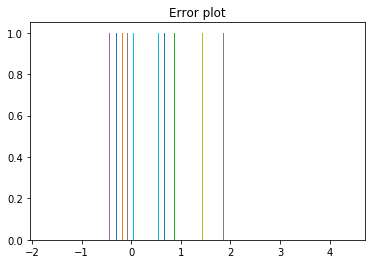

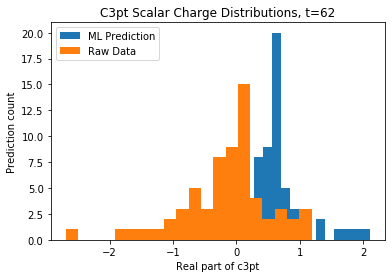

Prediction quality @ t=63: 0.24148300677274


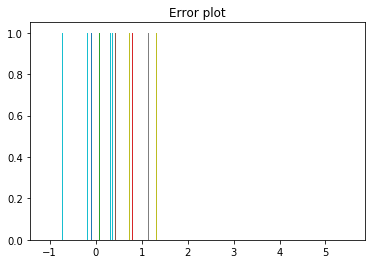

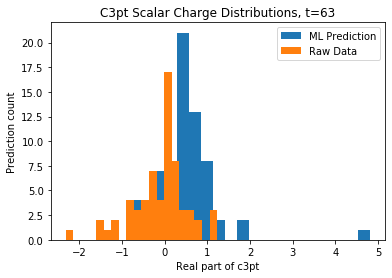

NameError: name 'Y_train' is not defined

In [7]:
for t in range(64):
    errors = []
    ML_samples = []
    DM_samples = []
    for i in range(len(X_test)):
        testImg = X_test[t][i]
        testLabel_up = Y_test_up[t][i]
        pred_up = gbr_up[t].predict([testImg]) + biasCrxn_up[t]
        errors.append(pred_up - testLabel_up)
        DM_samples.append(testLabel_up)
        ML_samples.append(pred_up[0])

    print("Prediction quality @ t=" + str(t) + ":", np.std(errors) / np.std(X_train[t]))
    
    plt.hist(errors, bins=20)
    plt.title("Error plot")
    plt.show()

    plt.hist(ML_samples, bins=20)
    plt.hist(DM_samples, bins=20)
    plt.legend(["ML Prediction", "Raw Data"])
    plt.xlabel("Real part of c3pt")
    plt.ylabel("Prediction count")
    plt.title("C3pt Scalar Charge Distributions, t=" + str(t))
    plt.show()

quals = []
for t in range(0, 64):
    if t % 8 == 1 and t != 1:
        quals.append(0)
        continue
    errors = []
    ML_samples = []
    DM_samples = []
    for i in range(len(X_test)):
        testImg = X_test[t][i]
        testLabel_up = Y_test_up[t][i]
        pred_up = gbr_up[t].predict([testImg]) + biasCrxn_up[t]
        errors.append(pred_up[0] - testLabel_up)
        ML_samples.append(pred_up[0])
        DM_samples.append(testLabel_up)

    quals.append(np.std(errors) / np.std(Y_train[t]))
    
for i in range(9, 64, 8):
    quals[i] = (quals[i-1] + quals[i + 1]) / 2

plt.plot(list(range(64)), quals)
plt.title("Prediction quality by time slice (t=9 thrown out)")
plt.show()

## Vector Charge Prediction

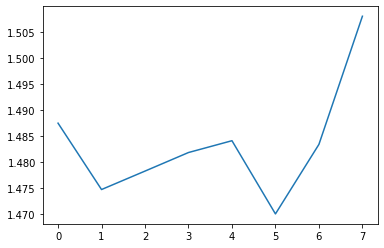

In [35]:
labelFrac = 0.3
BCFrac = 0.4

samps = 8

labelEnd = int(len(labels_S_up[0]) * labelFrac)
BCEnd    = int(len(labels_S_up[0]) * (BCFrac + labelFrac))

X_train, Y_train_up, Y_train_down = features[:, :labelEnd], labels_V_up[:, :labelEnd], labels_V_down[:, :labelEnd]
X_bc, Y_bc_up, Y_bc_down = features[:, labelEnd:BCEnd], labels_V_up[:, labelEnd:BCEnd], labels_V_down[:, labelEnd:BCEnd]
X_test, Y_test_up, Y_test_down = features[:, BCEnd:], labels_V_up[:, BCEnd:], labels_V_down[:, BCEnd:]

gbr_up = list(range(samps))
gbr_down = list(range(samps))
biasCrxn_up = list(range(samps))
biasCrxn_down = list(range(samps))
for i in range(samps):
    gbr_up[i] = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, max_depth=3)
    gbr_up[i].fit(X_train[i], Y_train_up[i])
    
    gbr_down[i] = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, max_depth=3)
    gbr_down[i].fit(X_train[i], Y_train_down[i])

    y_bc_pred_up = gbr_up[i].predict(X_bc[i])
    y_bc_pred_down = gbr_down[i].predict(X_bc[i])

    biasCrxn_up[i] = np.average(Y_bc_up - y_bc_pred_up)
    biasCrxn_down[i] = np.average(Y_bc_down - y_bc_pred_down)

Prediction quality @ t=0: 0.05360040706992417


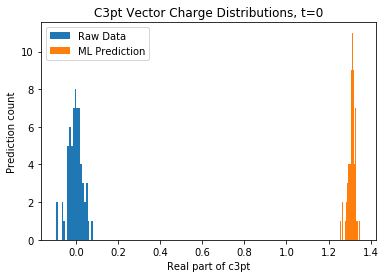

Prediction quality @ t=1: 0.04072957165056459


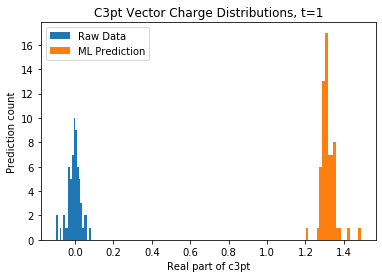

Prediction quality @ t=2: 0.043280492995710566


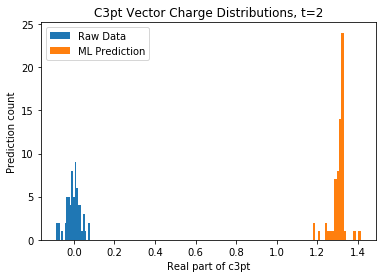

Prediction quality @ t=3: 0.05109210904699729


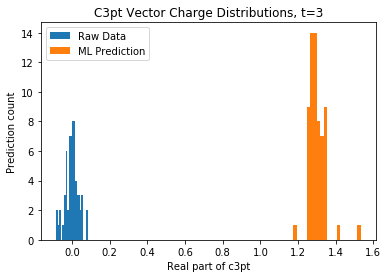

Prediction quality @ t=4: 0.032190335637608126


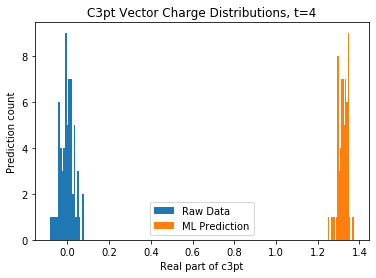

Prediction quality @ t=5: 0.03479344782862186


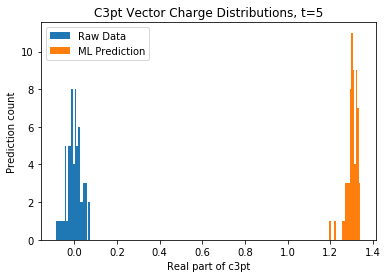

Prediction quality @ t=6: 0.0314209625768118


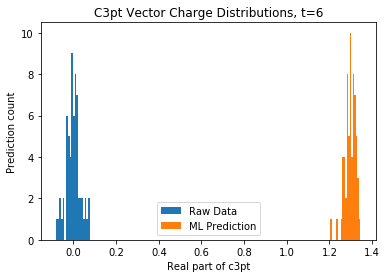

Prediction quality @ t=7: 0.054271069704233045


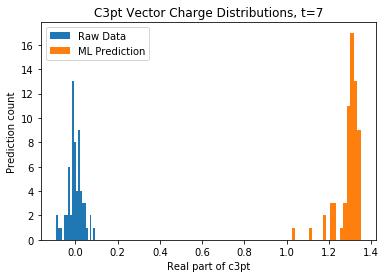

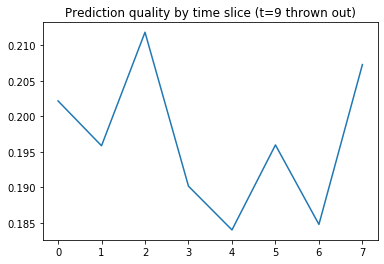

In [28]:
for t in range(samps):
    errors = []
    ML_samples = []
    DM_samples = []
    for i in range(len(X_test)):
        testImg = X_test[t][i]
        testLabel_up = Y_test_up[t][i]
        pred_up = gbr_up[t].predict([testImg]) + biasCrxn_up[t]
        errors.append(pred_up - testLabel_up)
        ML_samples.append(pred_up[0])
        DM_samples.append(testLabel_up)

    print("Prediction quality @ t=" + str(t) + ":", np.std(errors) / np.std(Y_train_up[t]))

    plt.hist(DM_samples, bins=20)
    plt.hist(ML_samples, bins=20)
    plt.legend(["Raw Data", "ML Prediction"])
    plt.xlabel("Real part of c3pt")
    plt.ylabel("Prediction count")
    plt.title("C3pt Vector Charge Distributions, t=" + str(t))
    plt.show()

quals = []
for t in range(0, samps):
    errors = []
    ML_samples = []
    DM_samples = []
    for i in range(len(X_test[t])):
        testImg = X_test[t][i]
        testLabel_up = Y_test_up[t][i]
        pred_up = gbr_up[t].predict([testImg]) + biasCrxn_up[t]
        errors.append(pred_up - testLabel_up)
        ML_samples.append(pred_up[0])
        DM_samples.append(testLabel_up)

    quals.append(np.std(errors) / np.std(Y_train_up[t]))
    
for i in range(9, samps, 8):
    quals[i] = (quals[i-1] + quals[i + 1]) / 2

plt.plot(list(range(samps)), quals)
plt.title("Prediction quality by time slice (t=9 thrown out)")
plt.show()

## Vector Charge Prediction With ML Bias Correction

In [38]:
labelFrac = 0.5

labelEnd = int(len(labels_V_up[0]) * labelFrac)

X_train, Y_train_up, Y_train_down = features[:, :labelEnd], labels_V_up[:, :labelEnd], labels_V_down[:, :labelEnd]
X_test, Y_test_up, Y_test_down = features[:, labelEnd:], labels_V_up[:, labelEnd:], labels_V_down[:, labelEnd:]

samps = 64

gbr_up = list(range(samps))
gbr_down = list(range(samps))
gbr_up_congl = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, max_depth=3)
gbr_down_congl = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, max_depth=3)

for i in range(samps):
    gbr_up[i] = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, max_depth=3)
    gbr_up[i].fit(X_train[i], Y_train_up[i])
    
    gbr_down[i] = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, max_depth=3)
    gbr_down[i].fit(X_train[i], Y_train_down[i])

# Y_train_up_avg = np.sum(Y_train_up, axis=0) / len(Y_train_up)
# Y_train_down_avg = np.sum(Y_train_down, axis=0) / len(Y_train_down)

# gbr_up_congl.fit(X_train[0], Y_train_up_avg)
# gbr_down_congl.fit(X_train[0], Y_train_down_avg)

Prediction quality @ t=0: 0.2683412313007251


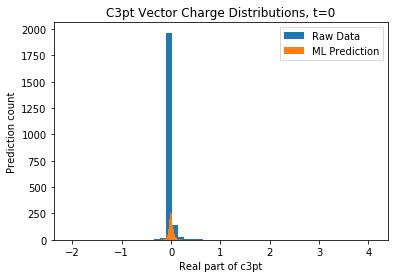

Prediction quality @ t=1: 0.2523528522529506


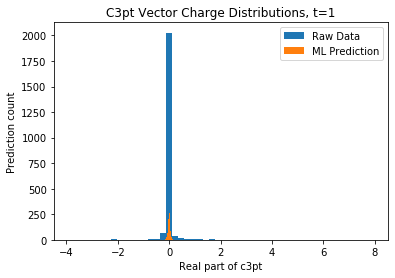

Prediction quality @ t=2: 0.2944282373516758


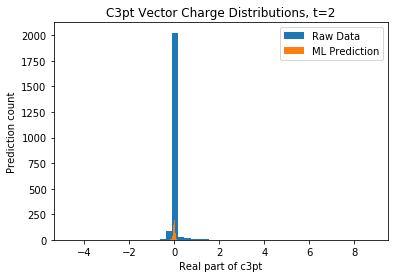

Prediction quality @ t=3: 0.21694484844580925


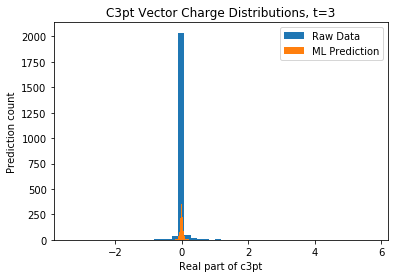

Prediction quality @ t=4: 0.2415937046898096


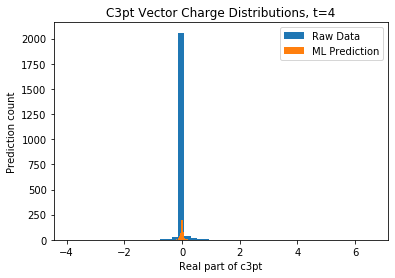

Prediction quality @ t=5: 0.26638933737046055


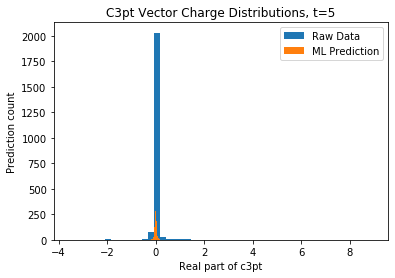

Prediction quality @ t=6: 0.24715368498063808


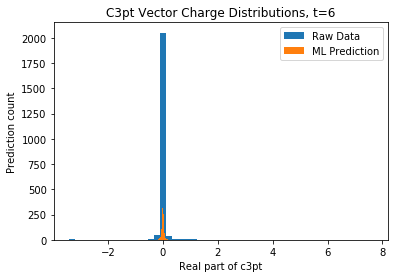

Prediction quality @ t=7: 0.2705337986236557


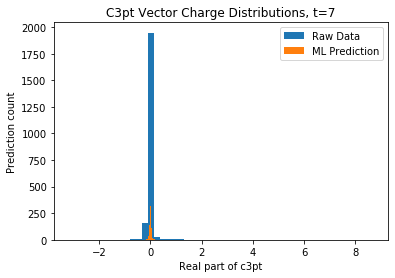

Prediction quality @ t=8: 0.39827315684724873


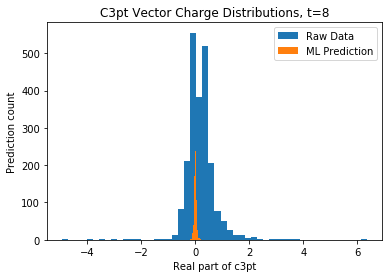

Prediction quality @ t=9: 0.4641729920157097


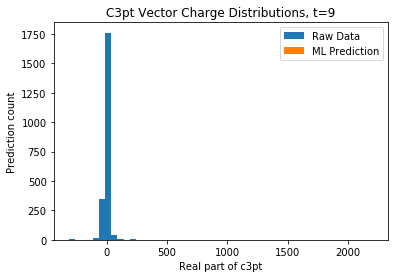

Prediction quality @ t=10: 0.6642282113731874


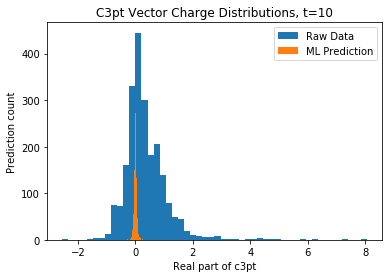

Prediction quality @ t=11: 0.6666835904149824


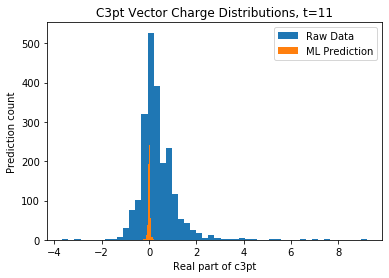

Prediction quality @ t=12: 0.6575101829464535


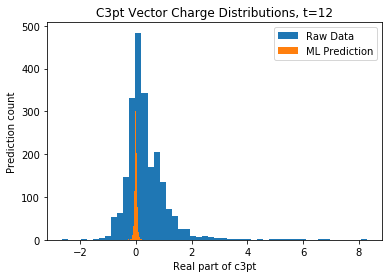

Prediction quality @ t=13: 0.6595207627544124


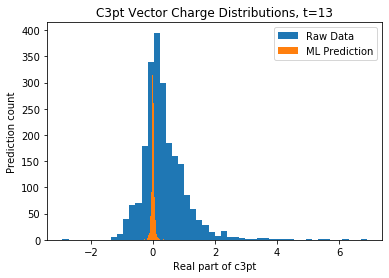

Prediction quality @ t=14: 0.6610864630623743


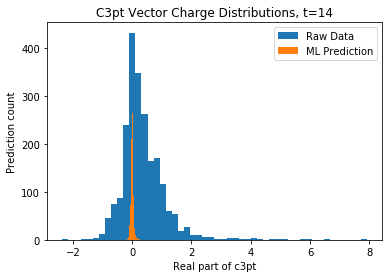

Prediction quality @ t=15: 0.6379852708196541


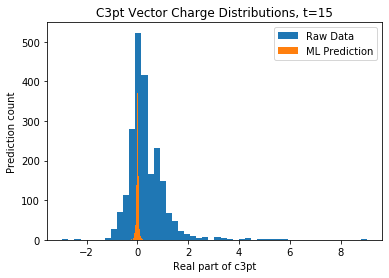

Prediction quality @ t=16: 0.8765337867598305


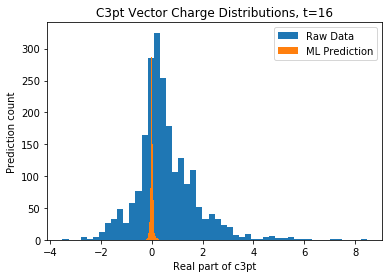

Prediction quality @ t=17: 0.5833093531755065


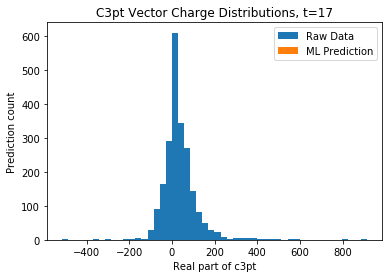

Prediction quality @ t=18: 0.6259382467925306


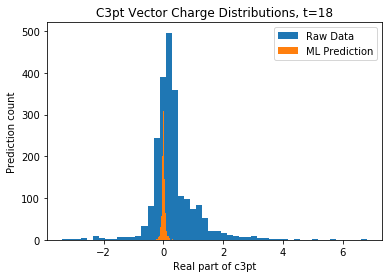

Prediction quality @ t=19: 0.6553304929059319


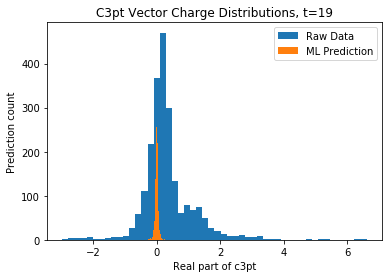

Prediction quality @ t=20: 0.6431474154196731


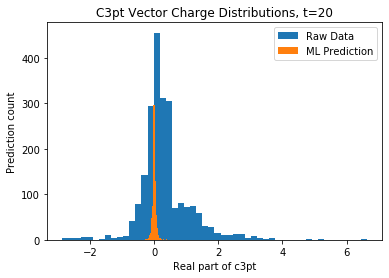

Prediction quality @ t=21: 0.6486717119469717


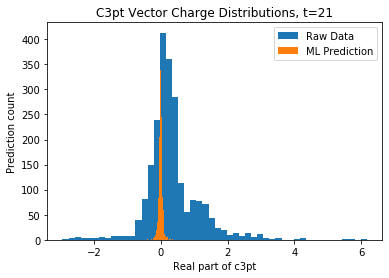

Prediction quality @ t=22: 0.6505366630493796


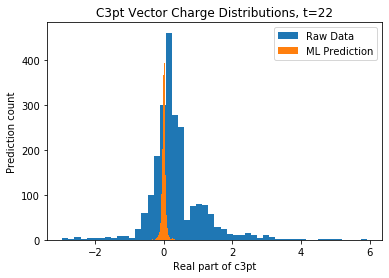

Prediction quality @ t=23: 0.642658547841957


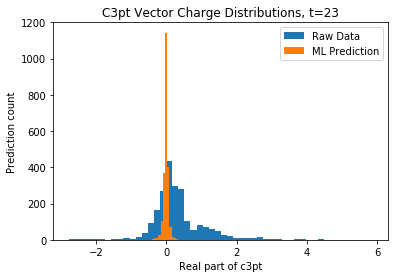

Prediction quality @ t=24: 0.771235007038127


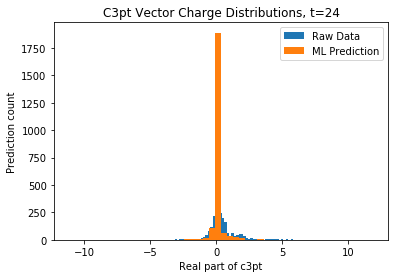

Prediction quality @ t=25: 0.6005938596696185


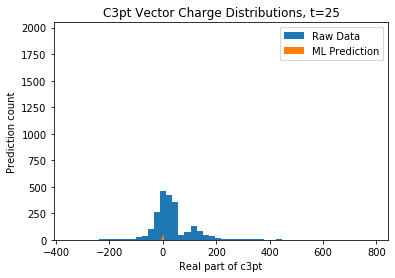

Prediction quality @ t=26: 1.2135197802745414


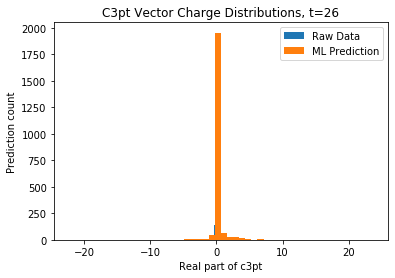

Prediction quality @ t=27: 1.2161371727549763


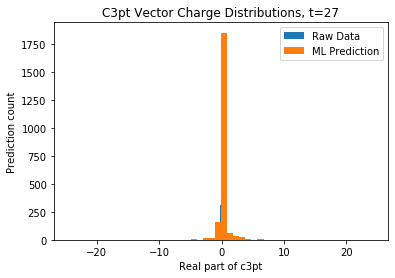

Prediction quality @ t=28: 1.2264505893952524


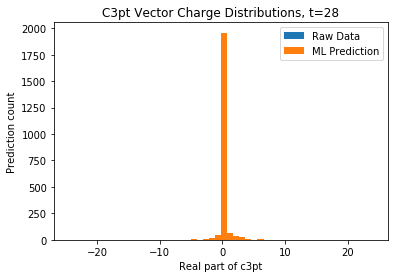

Prediction quality @ t=29: 1.2654278916747153


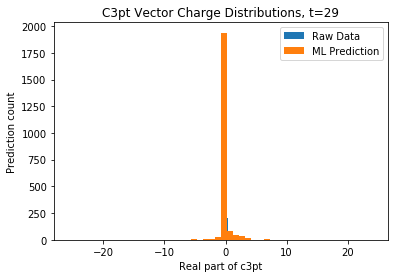

Prediction quality @ t=30: 1.2487976583775473


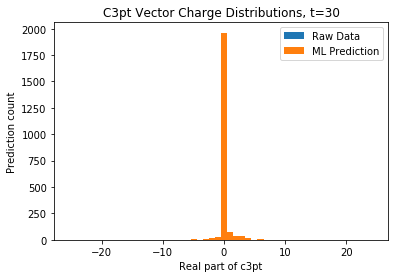

Prediction quality @ t=31: 1.2704785106502736


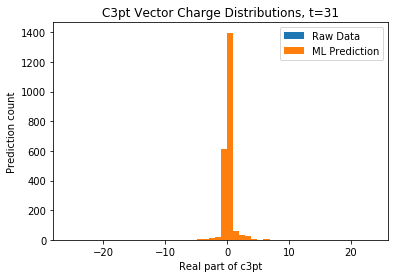

Prediction quality @ t=32: 1.2695048189847764


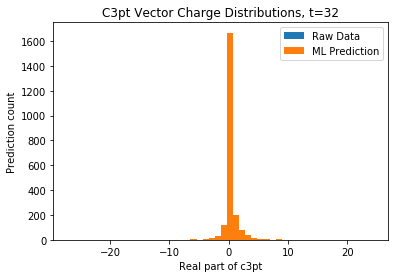

Prediction quality @ t=33: 1.2165006664901246


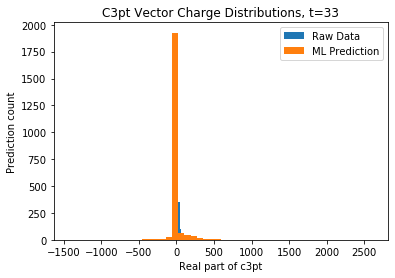

Prediction quality @ t=34: 17.429725675269925


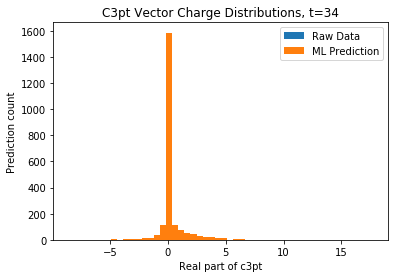

Prediction quality @ t=35: 21.3906608868643


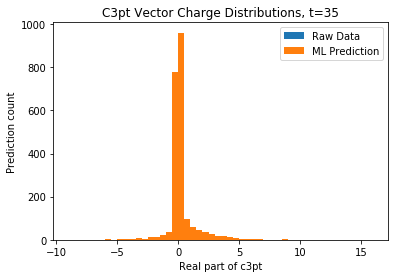

Prediction quality @ t=36: 21.299681104826384


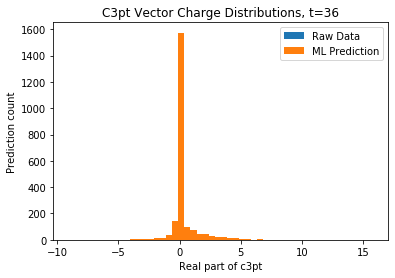

Prediction quality @ t=37: 22.42009728921604


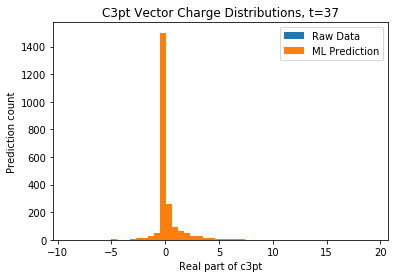

Prediction quality @ t=38: 23.135423765216313


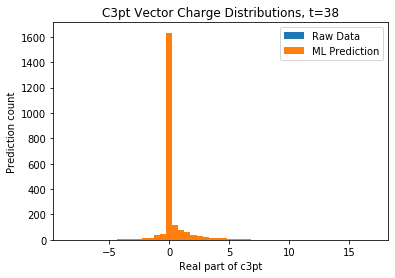

Prediction quality @ t=39: 23.45011213885676


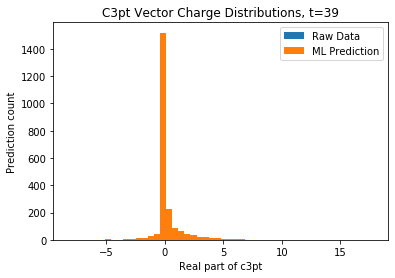

Prediction quality @ t=40: 27.274245648332112


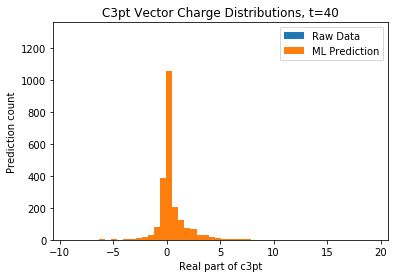

Prediction quality @ t=41: 2690.0633383012237


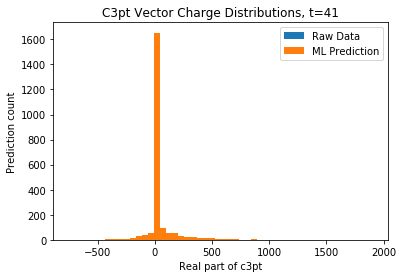

Prediction quality @ t=42: 23.800953755426367


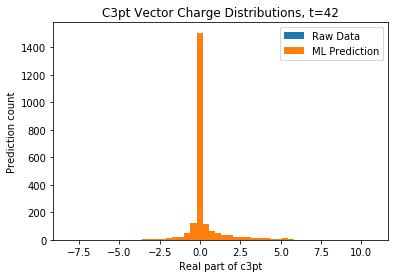

Prediction quality @ t=43: 23.853601508196192


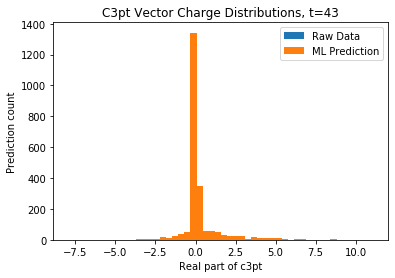

Prediction quality @ t=44: 23.25110447961615


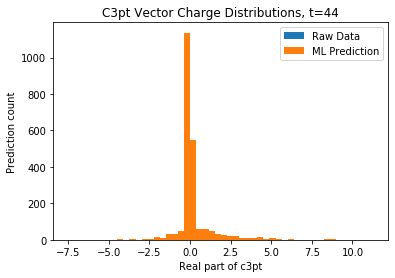

Prediction quality @ t=45: 24.36732881680437


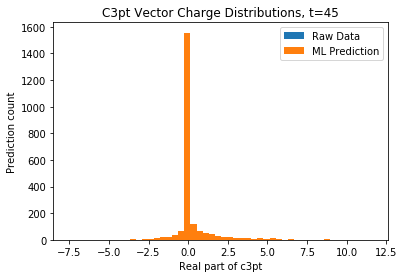

Prediction quality @ t=46: 24.312212615676433


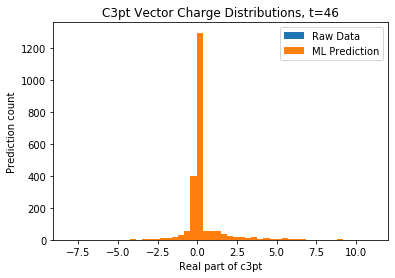

Prediction quality @ t=47: 24.223851098275198


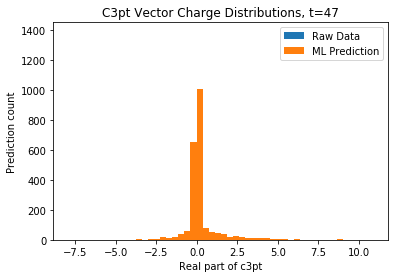

Prediction quality @ t=48: 27.619136436660067


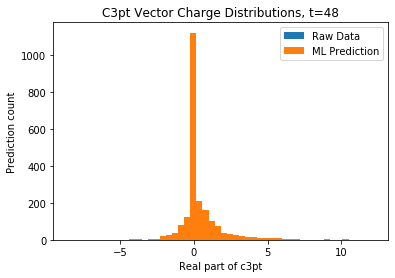

Prediction quality @ t=49: 2774.266433829482


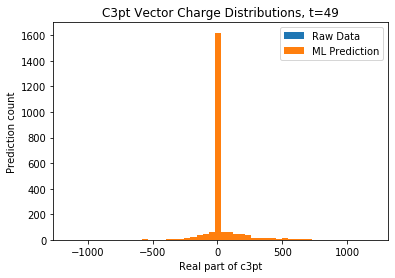

Prediction quality @ t=50: 23.993462732027236


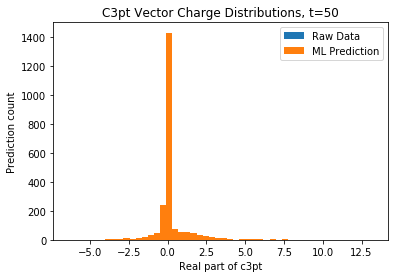

Prediction quality @ t=51: 23.370935789804424


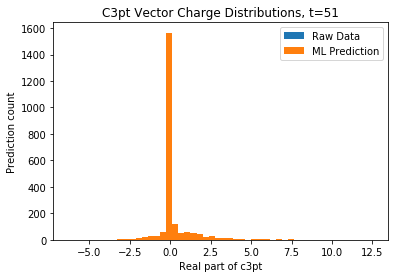

Prediction quality @ t=52: 23.107446829560157


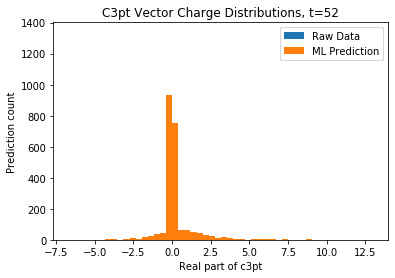

Prediction quality @ t=53: 23.027727204363003


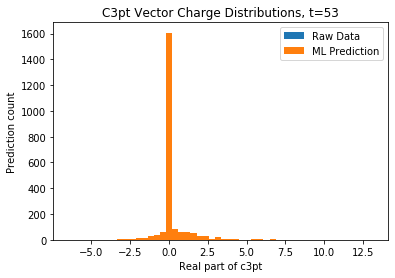

Prediction quality @ t=54: 22.489534751163784


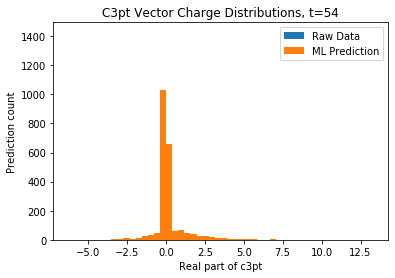

Prediction quality @ t=55: 22.485326336169614


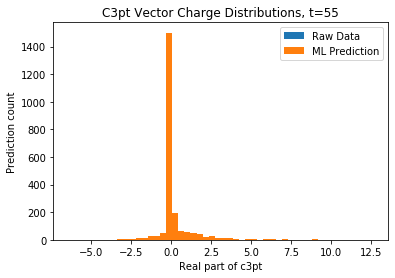

Prediction quality @ t=56: 22.008229505317704


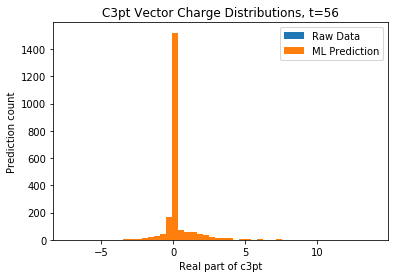

Prediction quality @ t=57: 2424.6252873311496


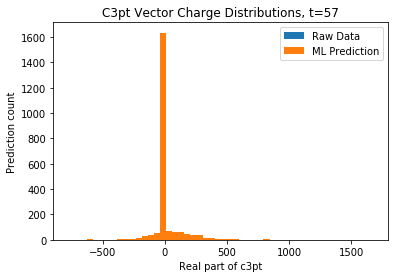

Prediction quality @ t=58: 1.5045059226979722


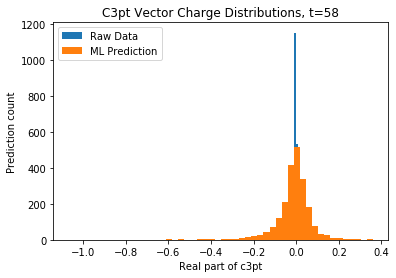

Prediction quality @ t=59: 1.1260581670869867


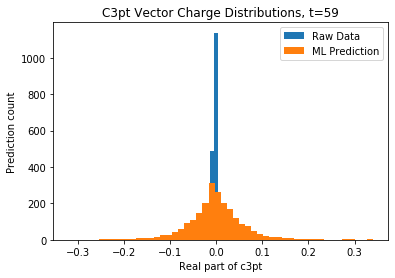

Prediction quality @ t=60: 0.9220008972893894


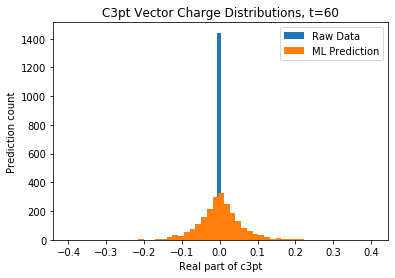

Prediction quality @ t=61: 0.9505092131205969


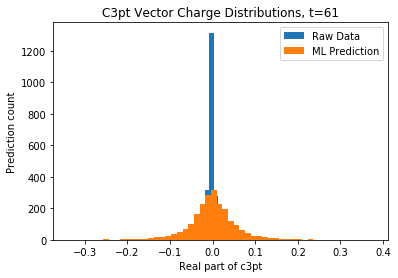

Prediction quality @ t=62: 0.8438712626968975


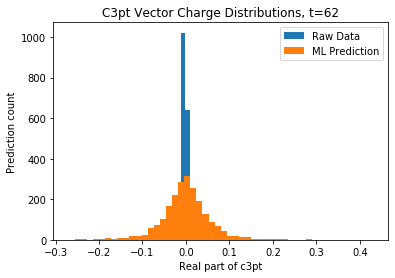

Prediction quality @ t=63: 0.6053185829188252


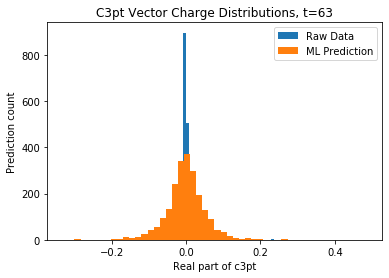

-0.0031464493094098085
-0.003988522762033801
-0.0037872064773838933
-0.0061938830509021695
-0.0023613388896238626
-0.006658835674693857
-0.004200452839851861
0.011052536738171548
-0.19729365984237804
-2.706006369375546
-0.356523232576503
-0.3492046115999003
-0.3554714357899886
-0.3538424210156748
-0.3597508111783434
-0.3381828718405018
-0.5364236056344053
-35.72728995861343
-0.3152918178633018
-0.3286046628122705
-0.32617877977419757
-0.33316214512862247
-0.33496905551884354
-0.3317271626209574
-0.3997023688445727
-35.95113352796443
-0.04870715515942677
-0.0658655161153029
-0.06210226621201985
-0.0638000102857295
-0.06894222569887179
-0.07567320594208023
0.06422837997308155
-5.542065438317426
0.28080527539994
0.2777085297740611
0.27556126046205054
0.27788355358364286
0.27778304983924734
0.2666372848638512
0.4268707685024155
26.018703959759016
0.24812024476408878
0.26265934553249703
0.26109165724570627
0.26320809028331105
0.25948110292187615
0.2531670966815709
0.39579137572168965
26.125

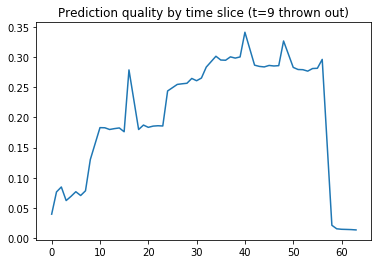

In [41]:
for t in range(samps):
    errors = []
    ML_samples = []
    DM_samples = []
    for i in range(len(X_test[t])):
        testImg = X_test[t][i]
        testLabel_up = Y_test_up[t][i]
        pred_up = gbr_up[t].predict([testImg])
        errors.append(pred_up[0] - testLabel_up)
        ML_samples.append(pred_up[0])
        DM_samples.append(testLabel_up)

    print("Prediction quality @ t=" + str(t) + ":", np.std(errors) / np.std(Y_train_up[t]))

    plt.hist(ML_samples, bins=50)
    plt.hist(DM_samples, bins=50)
    plt.legend(["Raw Data", "ML Prediction"])
    plt.xlabel("Real part of c3pt")
    plt.ylabel("Prediction count")
    plt.title("C3pt Vector Charge Distributions, t=" + str(t))
    plt.show()

quals = []
for t in range(0, 64):
    errors = []
    ML_samples = []
    DM_samples = []
    for i in range(len(X_test[t])):
        testImg = X_test[t][i]
        testLabel_up = Y_test_up[t][i]
        pred_up = gbr_up[t].predict([testImg])
        errors.append(pred_up[0] - testLabel_up)
        DM_samples.append(testLabel_up)
        ML_samples.append(pred_up[0])
        
    avgDiff = (sum(DM_samples) - sum(ML_samples)) / len(DM_samples)
    print(avgDiff)

    quals.append(np.std(errors) / np.std(X_train[t]))
    
for i in range(9, 64, 8):
    quals[i] = (quals[i-1] + quals[i + 1]) / 2

plt.plot(list(range(64)), quals)
plt.title("Prediction quality by time slice (t=9 thrown out)")
plt.show()